In [1]:
# import pandas, numpy, netwokrx, basemap and matplot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from mpl_toolkits.basemap import Basemap


In [2]:
# Read xlsx file and convert columns to DataFrame
db = pd.ExcelFile('airports.xlsx')
us_apt = pd.read_excel(db, 'us_apt')
us_flt = pd.read_excel(db, 'us_flt')


In [3]:
# Ensure the origin and destination airports of each airline exist in the US
us_flt1 = us_flt[(us_flt['airport_1'].isin(us_apt['IATA'])) & (us_flt['airport_2'].isin(us_apt['IATA']))]
us_flt1

passengers airport_1 airport_2  scheduled
1            78723       ABE       MDW          2
2            63613       ABE       ORD        133
3             5124       ABQ       BOS        124
4           166829       ABQ       BUR         75
5            41262       ABQ       BWI         68
...            ...       ...       ...        ...
211131      205023       XNA       EWR        107
211132      205024       XNA       HPN          3
211133      205025       XNA       JFK          8
211134      205026       XNA       LGA        224
211135      205027       XNA       SWF          1

[207364 rows x 4 columns]

In [4]:
airport1 = pd.DataFrame(us_flt1.airport_1.value_counts().reset_index(name='counts'))
airport1

index  counts
0     ORD    7533
1     MDW    7442
2     BOS    6864
3     DFW    6716
4     PVD    6596
..    ...     ...
161   LBE       3
162   BMI       1
163   STP       1
164   FNL       1
165   FYV       1

[166 rows x 2 columns]

In [5]:
airport2 = pd.DataFrame(us_flt1.airport_2.value_counts().reset_index(name='counts'))
airport2

index  counts
0     BWI    8790
1     DCA    8782
2     IAD    8629
3     TPA    6387
4     SFO    6363
..    ...     ...
148   FTW       1
149   SFB       1
150   VGT       1
151   HFD       1
152   CGX       1

[153 rows x 2 columns]

In [6]:
count = airport1.append(airport2).groupby('index').sum()
count

counts
index        
ABE        41
ABQ      2731
ACK        68
ACV         8
ACY       273
...       ...
TUS      2251
TYS      1048
VGT         5
VPS        67
XNA       523

[195 rows x 1 columns]

In [7]:
counts = pd.DataFrame({'IATA': count.index, 'total': count.counts})
counts.to_csv("1.csv")

In [8]:
# Combine the coordinates and total flights of each airport
cor = counts.merge(us_apt, on = 'IATA')
cor

IATA  total   Latitude   Longitude
0    ABE     41  40.652100  -75.440804
1    ABQ   2731  35.040199 -106.609001
2    ACK     68  41.253101  -70.060204
3    ACV      8  40.978100 -124.109001
4    ACY    273  39.457600  -74.577202
..   ...    ...        ...         ...
190  TUS   2251  32.116100 -110.941002
191  TYS   1048  35.811001  -83.994003
192  VGT      5  36.210701 -115.194000
193  VPS     67  30.483200  -86.525398
194  XNA    523  36.281898  -94.306801

[195 rows x 4 columns]

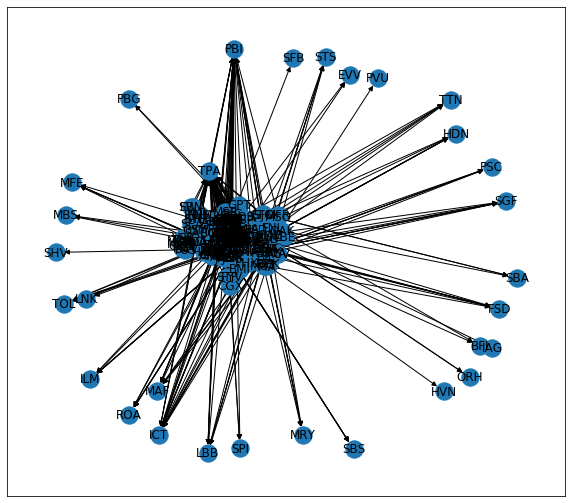

In [9]:
# Generate network with networkX
g1 = nx.from_pandas_edgelist(us_flt1, source = 'airport_1', target = 'airport_2',create_using = nx.DiGraph())
plt.figure(figsize = (10,9))
nx.draw_networkx(g1)
plt.show()

C:\Users\11811\anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys
C:\Users\11811\anaconda3\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\11811\anaconda3\lib\site-packages\ipykernel_launcher.py:28: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


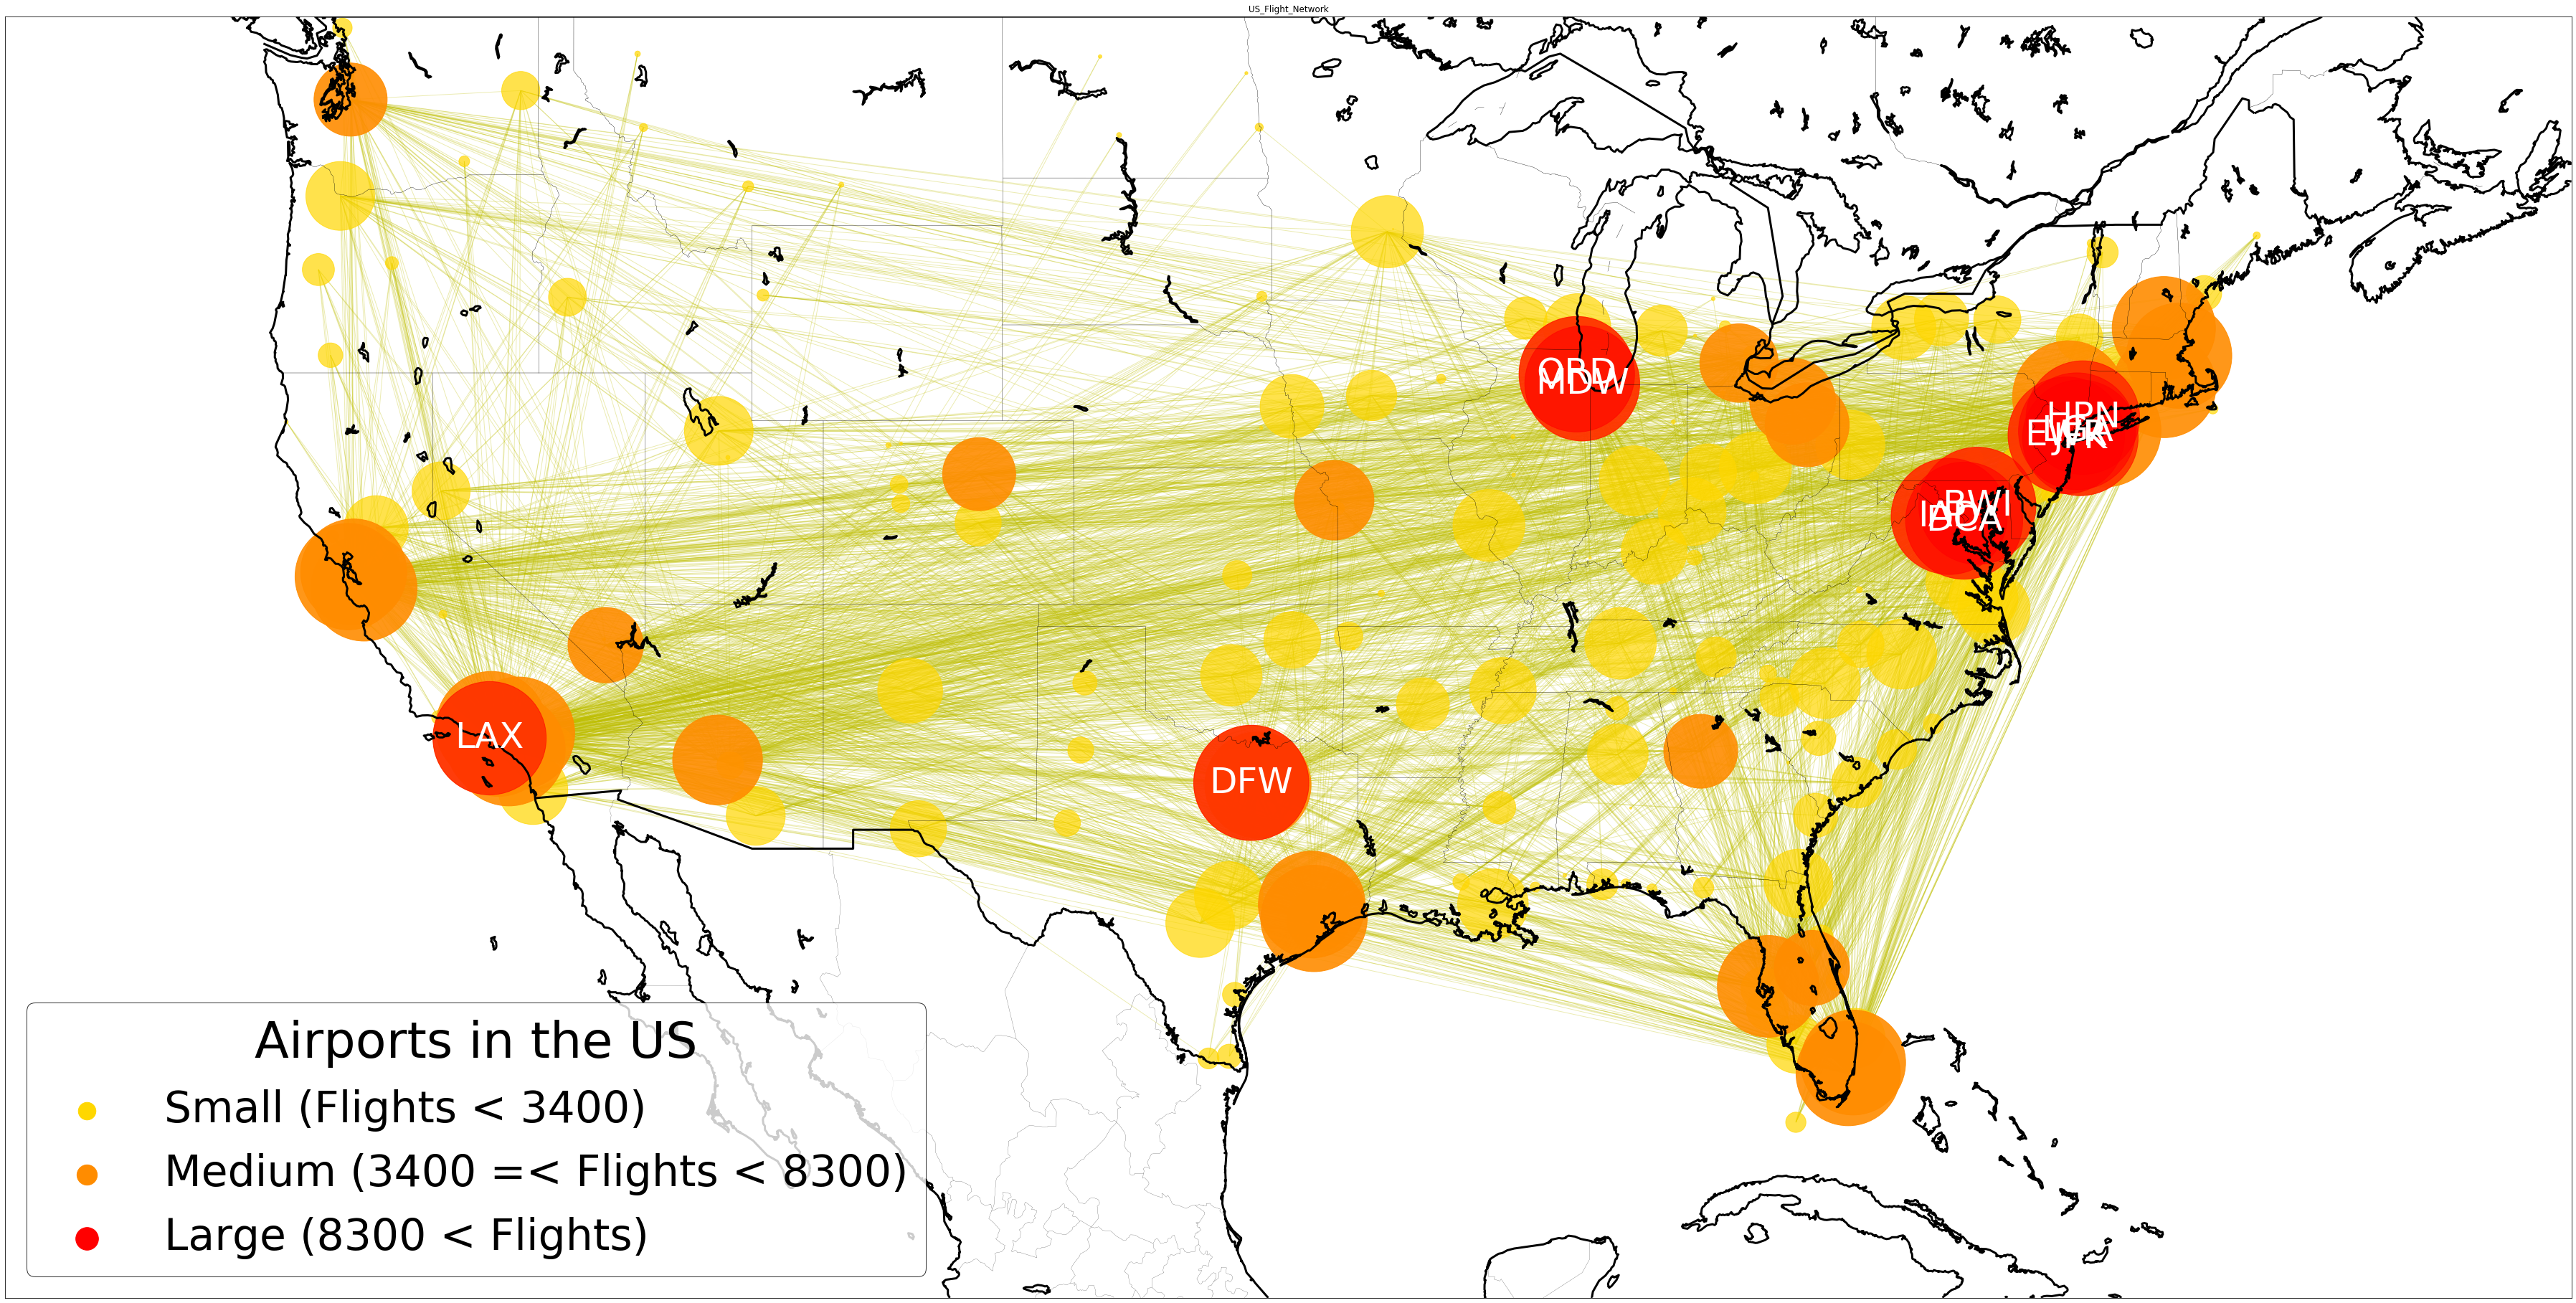

In [10]:
# Put the network on Basemap
# Create figure
plt.figure(figsize=(50,60))

# Set scale, resolution of map
m1 = Basemap(projection='merc',llcrnrlat=20,urcrnrlat=49,
            llcrnrlon=-132,urcrnrlon=-60,lat_ts=0,resolution='i',suppress_ticks=True)

# Extract coordinates from cor_data and create cor with a for loop
long, lat = m1(cor['Longitude'].values, cor['Latitude'].values)
coor = {}
for count, elem in enumerate (cor['IATA']):
    coor [elem] = (long[count], lat[count])

# draw nodes and edges  
nx.draw_networkx_edges(G = g1, pos = coor, edge_color = 'y', alpha=0.3,arrows = False)
nx.draw_networkx_nodes(G = g1, pos = coor, nodelist = [i for i in g1.nodes() if counts['total'][i] < 3400], node_color = 'gold', alpha = 0.7, node_size = [counts['total'][i]*3 for i in g1.nodes() if counts['total'][i] < 3400])
nx.draw_networkx_nodes(G = g1, pos = coor, nodelist = [i for i in g1.nodes() if counts['total'][i] > 3400], node_color = 'darkorange', alpha = 0.9, node_size = [counts['total'][i]*3 for i in g1.nodes() if counts['total'][i] > 3400 ])
nx.draw_networkx_nodes(G = g1, pos = coor, nodelist = [i for i in g1.nodes() if counts['total'][i] > 8300], node_color = 'red', alpha = 0.6, node_size = [counts['total'][i]*3 for i in g1.nodes() if counts['total'][i] > 8300])


nx.draw_networkx_labels(G = g1, pos = coor, font_size=50, font_color="white",
		                        labels = {i:i  for i in g1.nodes() if counts['total'][i] >= 8300})
# draw countries
m1.drawcountries(linewidth = 3)

# draw states
m1.drawstates(linewidth = 0.2)

# draw coastlines
m1.drawcoastlines(linewidth=3)

s = plt.scatter([],[], s=600, c='gold', marker = "o")
m = plt.scatter([],[], s=800, c='darkorange', marker = "o")
l = plt.scatter([],[], s=1000, c='red', marker = "o")
labels = ["Small (Flights < 3400)", "Medium (3400 =< Flights < 8300)", "Large (8300 < Flights)"]
plt.legend([s,m,l], labels, loc = 0, fontsize = 60, frameon = True, edgecolor = "black", title = "Airports in the US", title_fontsize = 70)

# automatically adjust
plt.tight_layout()

# plot title
plt.title("US_Flight_Network")

# save plot
plt.savefig("./images/US_Net.png", format = "png", dpi = 500)

plt.show()

NameError: name 'coor' is not defined